# MNIST Classification

The goal of this notebook is to implement a model consisting of just a softmax layer for classifying MNIST images, hence to perform a multiclass classification task. The notation follows the convention introduced for PW02:

<code>m</code>: Number of samples <br>
<code>n</code>: Number of features

Please follow the instructions in the cells below to conduct the following tasks:

1. Implement the functions to prepare the data (very similar to PW02).
2. Implement softmax, the cross entropy cost for multiclass and its gradient.
3. Implement the `optimize` function (with given function signature) by using the classes `Metrics` and `MiniBatches`.  
4. Run several trainings with different hyper-parameter settings and determine your favorite setting (1b).
5. Compute the Error Rates for the individual Digits (1c)
6. Analyze misclassified images with worst score (1d)
8. Plot the weights as images (1e)
7. Analyze different weights initialisation strategies (1f)

### Loading and Preparing the Data

Some preparatory steps to be applied before training:
* Imports: numpy and matplotlib
* Loading the data (same as for PW of previous week) 
* Some plot utilities
* Splitting the dataset into train and test
* Data Standarisation

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
### START YOUR CODE ### 
data_home = "./data"
### END YOUR CODE ### 

#### Load Data

In [3]:
from sklearn.datasets import fetch_openml

def load_mnist(data_home):
    """
    Loads the mnist dataset, prints the shape of the dataset and 
    returns the array with the images, the array with associated labels 
    and the shape of the images.     
    Parameters: 
    data_home -- Absolute path to the DATA_HOME  
    
    Returns:
    x -- array with images of shape (784,m) where m is the number of images
    y -- array with associated labels with shape (1,m) where m is the number of images
    shape -- (28,28)
    """
    mnist = fetch_openml(name='mnist_784', version=1, cache=True, data_home=data_home)
    x, y = mnist['data'].T, np.array(mnist['target'], dtype='int').T
    m = x.shape[1]
    y = y.reshape(1,m)
    print("Loaded MNIST original:")
    print("Image Data Shape" , x.shape)
    print("Label Data Shape", y.shape)
    return x,y,(28,28)


#### Plotting Utility

In [4]:
def plot_img(img, label, shape):
    """
    Plot the x array by reshaping it into a square array of given shape
    and print the label.
    
    Parameters:
    img -- array with the intensities to be plotted of shape (shape[0]*shape[1])
    label -- label 
    shape -- 2d tuple with the dimensions of the image to be plotted.
    """
    plt.imshow(np.reshape(img, shape), cmap=plt.cm.gray)
    plt.title("Label %i"%label)


def plot_digits(x,y,selection,shape, cols=5):
    """
    Plots the digits in a mosaic with given number of columns.

    Arguments:
    x -- array of images of size (n,m)
    y -- array of labels of size (1,m)
    selection -- list of selection of samples to be plotted
    shape -- shape of the images (a 2d tuple)
    selected_digits -- tuple with the two selected digits (the first associated with label 1, the second with label 0)
    """
    if len(selection)==0:
        print("No images in the selection!")
        return
    cols = min(cols, len(selection))
    rows = len(selection)/cols+1
    plt.figure(figsize=(20,4*rows))
    for index, (image, label) in enumerate(zip(x.T[selection,:], y.T[selection,:])):
        plt.subplot(rows, cols, index+1)
        plt.imshow(np.reshape(image, shape), cmap=plt.cm.gray)
        plt.title('Sample %i\n Label %i\n' % (selection[index],label), fontsize = 12)
    plt.tight_layout()

#### Split Data and reshape as specified

Split the data into training set and test set.
We use the scikit-learn function 'train_test_split' with 20\% test data.

Furthermore, we reshape input data x to (n,m).

In [5]:
from sklearn.model_selection import train_test_split

def prepare_train_test(x, y, test_size=0.20):
    """
    Split the dataset consisting of an array of images (shape (n, m)) and an array of labels (shape (1, m))
    into train and test set.
    
    Parameters:
    x -- Array of images of shape (n,m) where m is the number of samples
    y -- Array of labels of shape (1, m) where m is the number of samples
    test_size -- fraction of samples to reserve as test sample
    
    Returns:
    x_train -- np.ndarray of images of shape (n,m1) used for training
    y_train -- np.ndarray of labels of shape (1,m1) used for training
    x_test -- np.ndarray of images of shape (n,m2) used for testing
    y_test -- np.ndarray of labels of shape (1,m2) used for testing
    """
    # split 
    # train_test_split() expects x, y in shapes (m, *), (m, *) 
    
    out = train_test_split(x.T, y.T, test_size=0.20, random_state=1)
    
    # transpose back the output obtained from the train_test_split-function
    x_train, x_test, y_train, y_test = (x.T for x in out)
    
    print("Shape training set: ", x_train.shape, y_train.shape)
    print("Shape test set:     ", x_test.shape, y_test.shape)
    
    return x_train, x_test, y_train, y_test

#### Data Normalisation

Normalize the data - apply min/max normalization.


In [6]:
def normalize(x_train, x_test):
    """
    Normalizes pixel values using min-max normalization, min and max are calculated globally over all features n
    

    Parameters:
    x_train -- Array of training samples of shape (n,m1) where n,m1 are the number of features and samples, respectively.  
    x_test -- Array of test samples of shape (n,m2) where n,m2 are the number of features and samples, respectively. 
    
    Returns:
    The arrays with the normalized train and test samples.  
    """
    ### START YOUR CODE ###  
    
    x_train_min = np.min(x_train)
    x_train_max = np.max(x_train)
    
    x_train = 2*(x_train-x_train_min)/(x_train_max-x_train_min)-1
    x_test = 2*(x_test-x_train_min)/(x_train_max-x_train_min)-1
    
    ### END YOUR CODE ###     

    return x_train, x_test

#### Test normalization

In [7]:
x_train_unittest = np.array([[10, 5], [-5, -10]])
x_test_unittest = np.array([[10, 1], [0, -10]])
actual_train, actual_test = normalize(x_train_unittest, x_test_unittest)
expected_train, expected_test = np.array([[1, 0.5], [-0.5, -1]]), np.array([[1, 0.1], [0, -1]])
np.testing.assert_almost_equal(expected_train, actual_train)
np.testing.assert_almost_equal(expected_test, actual_test)

### Softmax

Implement the softmax function - actually, the softmax layer with given weights-matrix $W$ and bias-vector $b$. 

In [8]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z),axis=0)  # any column must sum up to 1

def predict(W, b, X):
    '''
    Compute the per class probabilities for all the m samples by using a softmax layer with parameters (W, b).
    
    Arguments:
    W -- weights, a numpy array with shape (ny, nx) (with ny=10 for MNIST).
    b -- biases, a numpy array with shape (ny,1)
    X -- input data of size (nx,m)
    
    Returns:
    A -- a numpy array of shape (ny,m) with the prediction probabilities for the digits.
    ''' 
    ### START YOUR CODE ###
    
    # page 29
    return softmax(np.dot(W,X)+b)
    
    ### END YOUR CODE ###

#### TEST Softmax

In [9]:
W = np.array([[1,-1],[0,1],[-1,1]]).reshape(3,2)
b = np.array([0,0,0]).reshape(3,1)
X = np.array([2, 3]).reshape(2,1)
A = predict(W,b,X)
Aexp = np.array([0.01587624,0.86681333,0.11731043]).reshape(A.shape)
np.testing.assert_array_almost_equal(A,Aexp,decimal=8)
np.testing.assert_array_almost_equal(np.sum(A, axis=0), 1.0, decimal=8)

X = np.array([[2,-1,1,-1],[1,1,1,1]]).reshape(2,4)
A = predict(W,b,X)
Aexp = np.array([[0.46831053, 0.01321289, 0.21194156, 0.01321289],
 [0.46831053, 0.26538793, 0.57611688, 0.26538793],
 [0.06337894, 0.72139918, 0.21194156, 0.72139918]]
)
np.testing.assert_array_almost_equal(A,Aexp,decimal=8)
np.testing.assert_array_almost_equal(np.sum(A, axis=0), np.ones(4,dtype='float'), decimal=8)

### Cost Function (Cross Entropy)

Implement the cross entropy cost function for the multi-class setting. 

For later use implement a function to create one-hot vectors.

In [10]:
def cost(Ypred, Y):
    """
    Computes the cross entropy cost function for given predicted values (Ypred) and labels (Y).
    
    Parameters:
    Ypred -- prediction from softmax, a numpy array of shape (ny,m)
    Y -- ground truth labels, a numpy array with shape (1,m) containing digits 0,1,...,9. 
    
    Returns:
    Cross Entropy Cost
    """
    ### START YOUR CODE ###  
    m,n = Ypred.shape
    J = -1/n*np.sum(np.log(Ypred[Y,range(n)]))
    return J
  
    ### END YOUR CODE ###

#### TEST Cross Entropy Cost 

In [11]:
Y = np.array([1])
Ypred = np.array([0.04742587,0.95257413]).reshape(2,1)
J = cost(Ypred,Y)
Jexp = 0.04858735
np.testing.assert_almost_equal(J,Jexp,decimal=8)

Y = np.array([1,1,1,0])
Ypred = np.array([[1.79862100e-02, 6.69285092e-03, 4.74258732e-02, 9.99088949e-01],
                  [9.82013790e-01, 9.93307149e-01, 9.52574127e-01, 9.11051194e-04]])
Jexp = 0.01859102
J = cost(Ypred,Y)
np.testing.assert_almost_equal(J,Jexp,decimal=8)

In [12]:
def onehot(y,n):
    """
    Constructs a one-hot-vector from a given array of labels (shape (1,m), containing numbers 0,1,...,n-1) 
    and the number of classes n.
    The resulting array has shape (n,m) and in row j and column i a '1' if the i-th sample has label 'j'. 
    
    Parameters:
    y -- labels, numpy array of shape (1,m) 
    n -- number of labels

    Returns:
    On-hot-encoded vector of shape (n,m)
    """
    
    ### START YOUR CODE ###
    '''
    m = y.shape[1]
    result = np.zeros((n,m))
    
    print("y: ",y)

    for j in range(m):
        result[y[0,j],j] = 1
    '''
    
    m = y.shape[1]
    result = np.zeros((n,m),dtype=float)
    result[y[0,:],np.arange(m)] = 1
    
    ### START YOUR CODE ###
    return result

In [13]:
## Test one-hot vector implementation ##
Y = np.array([1,3,0]).reshape(1,3)
onehot_comp = onehot(Y,4)
onehot_exp = np.array([[0,0,1],[1,0,0],[0,0,0],[0,1,0]]).reshape(4,3)
np.testing.assert_almost_equal(onehot_exp,onehot_comp,decimal=8)

### Update Rules for the Parameters

Implement the (estimate of) gradient of the cost function (cross entropy implemented above) with respect to the parameters of the softmax layer.
The contributions from the different samples given in $X$ and $Y$ should be averaged.

In [14]:
def gradient(X, Y, A):
    """
    Computes the components of the gradient w.r.t. weights and bias - by using the cross entropy cost. 
    
    Arguments:
    X -- input data of size (nx,m)
    Y -- output labels - a numpy array with shape (1,m).
    A -- predicted scores (as output of softmax) - a numpy array with shape (ny,m) 
    
    Returns:
    gradJ -- dictionary with the gradient w.r.t. W (key "dW" with shape (ny,nx)) and w.r.t. b (key "db" with shape (ny,1))
    """
    ### START YOUR CODE ### 
    
    #Ypred = predict(W,b,X)
    m,n = A.shape
    
    mask = onehot(Y,m)
    
    gradJ = {}
    gradJ["dW"] = -1/n * np.dot(mask-A,X.T)
    gradJ["db"] = -1/n * np.sum(mask-A,axis=1).reshape(m,1)
    
    return gradJ
    
    ### END YOUR CODE ###
    

#### Test the Calculation of the Gradient

In [15]:
W = np.array([[1,-1],[0,1],[-1,1]]).reshape(3,2)
b = np.array([0,0,0]).reshape(3,1)
X = np.array([[2,-1,1,-1],[1,1,1,1]]).reshape(2,4)
A = predict(W,b,X)

Y = np.array([1,1,1,1]).reshape(1,4)

gradJ = gradient(X,Y,A)
dW = gradJ['dW']
db = gradJ['db']
dWexp = np.array([[ 0.28053421,0.17666947],
                  [-0.00450948,-0.60619918],
                  [-0.27602473,0.42952972]]).reshape(3,2)
dbexp = np.array([0.17666947,-0.60619918,0.42952972]).reshape(3,1)
np.testing.assert_array_almost_equal(dW,dWexp,decimal=8)
np.testing.assert_array_almost_equal(db,dbexp, decimal=8)

### Metrics for measuring the performance of the algorithm

As metrics we compute the error rate as number of wrong predictions divided by the number of samples. 

In [16]:
def error_rate(Ypred, Y):
    """
    Compute the error rate defined as the fraction of misclassified samples.
    
    Arguments:
    Ypred -- Predicted label, a numpy array of size (1,m)
    Y -- ground truth labels, a numpy array with shape (1,m)

    Returns:
    error_rate 
    """
    Ypredargmax = np.argmax(Ypred, axis=0)
    return np.mean(Y != Ypredargmax)

### Optimize (Learn)

As in PW02, we first provide the metrics class that is used for tracking progress during the training (by collecting suitable quantities).

In [17]:
class Metrics():
    """
    Allows to collect statistics (such as classification error or cost) that are of interest over the course of training
    and for creating learning curves that are a useful tool for analyzing the quality of the learning.
    """
    
    def __init__(self, cost, smooth=False):
        """
        Constructor for a metrics object. 
        Initializes all the statistics to track in form of python lists.
        
        Parameters:
        cost -- cost function to use (a python function)
        smooth -- if set to true updates learning curve after each training step and also provides learning curves 
        smoothed over the epoch  
        """
        self.epochs = []
        self.smooth = smooth
        self.train_costs_last = []
        self.test_costs_last = []
        self.train_errors_last = []
        self.test_errors_last = []
        self.stepsize_w_last = []
        self.stepsize_b_last = []
        if self.smooth:
            self.train_costs_smoothed = []
            self.test_costs_smoothed = []
            self.train_errors_smoothed = []
            self.test_errors_smoothed = []
            self.stepsize_w_smoothed = []
            self.stepsize_b_smoothed = []

        self.cost_function = cost
        self.init_epoch()

            
    def init_epoch(self):
        self.train_costs_epoch = []
        self.test_costs_epoch = []
        self.train_errors_epoch = []
        self.test_errors_epoch = []
        self.stepsize_w_epoch = []
        self.stepsize_b_epoch = []
        
        
    def update_epoch(self, epoch):
        """
        Computes the average of the metrics over the epoch and adds the result to the per epoch history
        
        Parameters:
        epoch -- the epoch to add to the per epoch cache
        """
        self.epochs.append(epoch)
        if self.smooth:
            self.train_costs_smoothed.append(np.mean(self.train_costs_epoch))
            self.test_costs_smoothed.append(np.mean(self.test_costs_epoch))
            self.train_errors_smoothed.append(np.mean(self.train_errors_epoch))
            self.test_errors_smoothed.append(np.mean(self.test_errors_epoch))
            self.stepsize_w_smoothed.append(np.mean(self.stepsize_w_epoch))
            self.stepsize_b_smoothed.append(np.mean(self.stepsize_b_epoch))                    

        self.train_costs_last.append(self.train_costs_epoch[-1])
        self.test_costs_last.append(self.test_costs_epoch[-1])
        self.train_errors_last.append(self.train_errors_epoch[-1])
        self.test_errors_last.append(self.test_errors_epoch[-1])
        self.stepsize_w_last.append(self.stepsize_w_epoch[-1])
        self.stepsize_b_last.append(self.stepsize_b_epoch[-1])                    
        
        self.init_epoch()
    
        
    def update_iteration(self, ypred_train, y_train, ypred_test, y_test, dw, db):
        """
        Allows to update the statistics to be tracked for a new epoch.
        The cost is computed by using the function object passed to the constructor.
        
        Parameters:
        epoch -- Epoch
        ypred_train -- predicted values on the training samples, a numpy array of shape (1,m1)
        y_train -- ground truth labels associated with the training samples, a numpy array of shape (1,m1)
        ypred_test -- predicted values on the test samples, a numpy array of shape (1,m2)
        y_test -- ground truth labels associated with the test samples, a numpy array of shape (1,m2)
        dw -- some lenght measure for the gradient w.r.t. the weights, a numpy array of shape (1,n)
        db -- gradient w.r.t. the bias, a scalar
        """
        Jtrain = self.cost_function(ypred_train, y_train)
        Jtest = self.cost_function(ypred_test, y_test)
        train_error = error_rate(ypred_train, y_train)
        test_error = error_rate(ypred_test, y_test)

        self.train_costs_epoch.append(Jtrain)
        self.test_costs_epoch.append(Jtest)
        self.train_errors_epoch.append(train_error)
        self.test_errors_epoch.append(test_error)
        self.stepsize_w_epoch.append(dw)
        self.stepsize_b_epoch.append(db)
        
        
    def print_latest_errors(self):
        print ("Train/test error after epoch %i: %f, %f" %(self.epochs[-1], self.train_errors_last[-1], self.test_errors_last[-1]))

    def print_latest_costs(self):
        print ("Train/test cost after epoch %i: %f, %f" %(self.epochs[-1], self.train_costs_last[-1], self.test_costs_last[-1]))

    def plot_cost_curves(self, ymin=None, ymax=None, smooth=True, logy=True):
        minvalue = 1e-5
        if logy:
            plt.semilogy(self.epochs, self.train_costs_last, "b-", label="train")
            plt.semilogy(self.epochs, self.test_costs_last, "r-", label="test")
            if self.smooth:
                plt.semilogy(self.epochs, self.train_costs_smoothed, "b--", label="train_smoothed")
                plt.semilogy(self.epochs, self.test_costs_smoothed, "r--", label="test_smoothed")
        else:
            plt.plot(self.epochs, self.train_costs_last, "b-", label="train")
            plt.plot(self.epochs, self.test_costs_last, "r-", label="test")   
            minvalue = 0.0
            if self.smooth:
                plt.plot(self.epochs, self.train_costs_smoothed, "b--", label="train_smoothed")
                plt.plot(self.epochs, self.test_costs_smoothed, "r--", label="test_smoothed")
        plt.ylabel('Cost')
        plt.xlabel('Epochs')
        xmax = self.epochs[-1]
        if not ymin:
            ymin = min(max(1e-5,np.min(self.train_costs_last)),max(1e-5,np.min(self.test_costs_last))) * 0.8
        if not ymax:
            ymax = max(np.max(self.train_costs_last),np.max(self.test_costs_last)) * 1.2
        plt.axis([0,xmax,ymin,ymax])
        plt.legend()
        plt.show()        
    
    def plot_error_curves(self, ymin=None, ymax=None, smooth=True, logy=True):
        minvalue = 1e-5
        if logy:
            plt.semilogy(self.epochs, self.train_errors_last, "b-", label="train")
            plt.semilogy(self.epochs, self.test_errors_last, "r-", label="test")
            if self.smooth:
                plt.semilogy(self.epochs, self.train_errors_smoothed, "b--", label="train_smoothed")
                plt.semilogy(self.epochs, self.test_errors_smoothed, "r--", label="test_smoothed")
        else: 
            plt.plot(self.epochs, self.train_errors_last, "b-", label="train")
            plt.plot(self.epochs, self.test_errors_last, "r-", label="test")
            minvalue = 0.0
            if self.smooth:
                plt.plot(self.epochs, self.train_errors_smoothed, "b--", label="train_smoothed")
                plt.plot(self.epochs, self.test_errors_smoothed, "r--", label="test_smoothed")
        plt.ylabel('Errors')
        plt.xlabel('Epochs')
        xmax = self.epochs[-1]
        if not ymin:
            ymin = min(max(1e-5,np.min(self.train_errors_last)),max(1e-5,np.min(self.test_errors_last))) * 0.8
        if not ymax:
            ymax = max(np.max(self.train_errors_last),np.max(self.test_errors_last)) * 1.2
        plt.axis([0,xmax,ymin,ymax])
        plt.legend()
        plt.show()        

    def plot_stepsize_curves(self, ymin=None, ymax=None, smooth=True):
        plt.semilogy(self.epochs, self.stepsize_w_last, label="dw")
        plt.semilogy(self.epochs, self.stepsize_b_last, label="db")
        if self.smooth and smooth:
            plt.semilogy(self.epochs, self.stepsize_w_smoothed, label="dw--")
            plt.semilogy(self.epochs, self.stepsize_b_smoothed, label="db--")
        plt.ylabel('Step Sizes (dw,db)')
        plt.xlabel('Epochs')
        xmax = self.epochs[-1]
        if not ymin:
            ymin = min(max(1e-5,np.min(self.stepsize_w_last)),max(1e-5,np.min(self.stepsize_b_last))) * 0.8
        if not ymax:
            ymax = max(np.max(self.stepsize_w_last),np.max(self.stepsize_b_last)) * 1.2
        plt.axis([0,xmax,ymin,ymax])
        plt.legend()
        plt.show()        
 

In addition, we provide a utility class that allows to create mini-batches from the given dataset $(X,Y)$ with given batch size and initially shuffled. 

In [18]:
class MiniBatches():
    """
    Is initialized (constructed) with features x of shape (nx,m) and the labels y of shape (1,m).
    Is reshuffled at construction time.
    
    Then, a next minibatch (MBX,MBY) with MBX of shape (nx,batchsize) and MBY of shape (1,batchsize) is provided by calling next() on the object. 
    """    
    def __init__(self, x, y, batchsize):
        self.x = x
        self.y = y
        m = x.shape[1]
        if not batchsize:
            self.batchsize = m
        else:
            self.batchsize = batchsize
        self.n = x.shape[0]
        self.mb = int(m/batchsize)
        self.indices = np.arange(m)
        np.random.shuffle(self.indices)
        self.ib = 0
        
    def number_of_batches(self):
        return self.mb
        
    def next(self):
        it = self.indices[self.ib*self.batchsize:(self.ib+1)*self.batchsize]
        xbatch = self.x[:,it].reshape(self.n,self.batchsize)
        ybatch = self.y[:,it].reshape(1,self.batchsize)
        self.ib += 1
        return xbatch, ybatch


#### Optimisation

This function should implement the training loop - adopting mini-batch gradient descent with arbitrary batch size. Implement the given function signature. 

In [19]:
def optimize(W, b, x_train, y_train, x_test, y_test, nepochs, alpha, batchsize=32, debug=False):
    """
    This function optimizes W and b by running (mini-batch) gradient descent. It starts with the given 
    weights as initial values and then iteratively updates the parameters for nepochs number of times.
    It returns the trained parameters as dictionary (keys "W" and "b") and various quantities 
    collected during learning in form of a Metrics object. The data (x_train, etc.) is assumed to contain 
    m1 training and m2 test samples.
    
    Arguments:
    W -- weights, a numpy array of size (ny,nx)
    b -- biases, a numpy array with shape (ny,1) (with ny=10 for MNIST).
    x_train -- input data for training of shape (nx,m1)
    y_train -- ground-truth labels - a numpy array with shape (1,m1)
    x_test -- input data for training of shape (nx,m2)
    y_test -- ground-truth labels - a numpy array with shape (1,m2)
    nepochs -- number of iterations of the optimization loop
    alpha -- learning rate of the gradient descent update rule
    batchsize -- batch size, defaults to 32
    debug -- if true prints training and test error values after each epoch. Defaults to True.
    
    Returns:
    params -- dictionary containing the (final) weights w and bias b
    metrics -- contain the information about the learning curves
    """ 
    metrics = Metrics(cost = cost)

    m = x_train.shape[1] # number of samples
    nx = x_train.shape[0] # number of input features
    mb = int(m/batchsize) # number of mini-batches
    print("Optimisation with batchsize %i and %i number of batches per epoch."%(batchsize,mb))
    
    # compute and set the initial values for the metrics curves
    ypred_train = predict(W,b,x_train)    
    ypred_test = predict(W,b,x_test)    
    metrics.update_iteration(ypred_train, y_train, ypred_test, y_test, 0, 0)
    metrics.update_epoch(0)
    
    # Loop over the epochs    
    for i in range(nepochs):
                
        # prepare shuffled mini-batches for this epoch
        batches = MiniBatches(x_train, y_train, batchsize)
        
        ### START YOUR CODE ### 
        '''
        If you run batch update, every parameter update requires
        your algorithm see each of the n training instances
        exactly once, i.e., every epoch your parameters are
        updated once.

        If you run mini-batch update with batch size = b, every
        parameter update requires your algorithm see b of n
        training instances, i.e., every epoch your parameters
        are updated about n/b times.

        If you run SGD update, every parameter update requires
        your algorithm see 1 of n training instances, i.e.,
        every epoch your parameters are updated about n times.
        
        Link:
        https://stats.stackexchange.com/questions/117919/what-are-the-differences-between-epoch-batch-and-minibatch
        '''    
        # navigate towards local minima with gradient descent on behalf of mini-batches
        for mini_batch in range(batches.number_of_batches()):
            x_train_mini, y_train_mini = batches.next()
            
            ypred_train_mini = predict(W,b,x_train_mini)
            
            gradJ = gradient(x_train_mini,y_train_mini,ypred_train_mini)
            dW = alpha * gradJ["dW"]
            db = alpha * gradJ["db"]
            W = W - dW
            b = b - db

        ypred_train = predict(W,b,x_train)
        ypred_test = predict(W,b,x_test)

        metrics.update_iteration(ypred_train, y_train, ypred_test, y_test, dW, db)

        ### END YOUR CODE ### 
            
        metrics.update_epoch(i+1)
            
        if debug:
            metrics.print_latest_errors()
        
    metrics.print_latest_costs()
    metrics.print_latest_errors()

    return {"W": W, "b": b}, metrics    

#### Initialize Parameters

Implement a utility to generate intialized parameters. 

As part of exercise 1f (below), different strategies should be considered. In a first round (exercise 1b and following) just use the first setting below (with weights and bias equals 0).

1. All weights and biases set to zero: $b=0, W=0$
2. Biases set to zero, weights generated as independent standard normal random numbers (mean zero, standard deviation 1)
3. Biases set to zero, weights generated as independent normal random numbers with mean zero and standard deviation properly scaled (divided by $\sqrt{n}$)

In [20]:
def initialize_params(nx, ny):
    """
    This function provides initialized parameters: a weights matrix and a bias vector. 
    
    Argument:
    nx -- number of input features
    ny -- number of output dimensions (number of different labels)
    
    Returns:
    w -- initialized weights matrix of shape (ny,nx)
    b -- initialized bias vector of shape (ny,1)
    """
    ### START YOUR CODE ### 
    
    # initialize weights (enable one line only!)
    w = np.zeros((ny,nx))
    #w = np.random.randn(ny,nx)
    #w = np.random.normal(0,1/np.sqrt(nx),(ny,nx))
    
    # initialize biases to zero
    b = np.zeros((ny,1))
    
    ### END YOUR CODE ### 
    
    return w, b

In [21]:
x,y, shape = load_mnist(data_home)
x_train1, x_test1, y_train, y_test = prepare_train_test(x, y, test_size=0.20)
x_train,x_test = normalize(x_train1,x_test1)

Loaded MNIST original:
Image Data Shape (784, 70000)
Label Data Shape (1, 70000)
Shape training set:  (784, 56000) (1, 56000)
Shape test set:      (784, 14000) (1, 14000)


#### Run the Training for Specific Setting and Plot Learning Curves

Run the training of the model with a first setting (e.g. alpha=0.2, nepochs=20, batchsize=64).

Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test cost after epoch 20: 0.452746, 0.568747
Train/test error after epoch 20: 0.097964, 0.109929


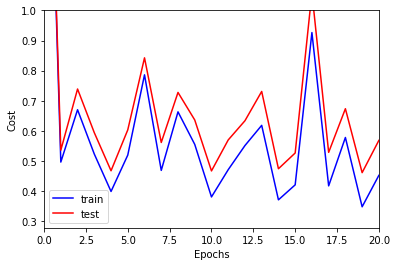

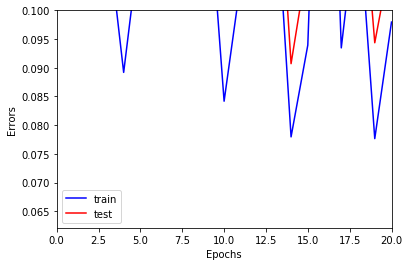

Train/test error after epoch 20: 0.097964, 0.109929


In [22]:
W,b = initialize_params(28*28, 10)

### START YOUR CODE ### 

alpha = 0.2
nepochs = 20
batchsize = 64

params, metrics = optimize(W, b, x_train, y_train, x_test, y_test, nepochs=nepochs, alpha=alpha, batchsize=batchsize, debug=False)

### END YOUR CODE ### 

metrics.plot_cost_curves(ymin=0.0, ymax=1.0,logy=False)
metrics.plot_error_curves(ymin=0.0, ymax=0.1,logy=False)
metrics.print_latest_errors()


### 1b Explore Hyper-Parameter Settings and Describe your Findings

Now run the training with different settings: 
* Different learning rate
* Different number of epochs
* Different batch size 

Explore which combination is best suited to obtain good test performance. Keep an eye on random estimates for the error rates due to random parameter initialisation and randomly shuffled mini-batches. 

Specify your choice of these hyper-parameters and justify why you consider your choice best suited.

In [23]:
import itertools

param_learning_rate = [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.8]
param_nepochs = [20, 40, 80]
param_batchsize = [16, 32, 64]

hyper_param_results = []
for learning_rate, nepochs, batchsize in itertools.product(param_learning_rate, param_nepochs, param_batchsize):
    print("Learning Rate:", learning_rate, ", Num of Epochs:", nepochs, ", BatchSize:", batchsize)
    params, metrics = optimize(W, b, x_train, y_train, x_test, y_test, nepochs=nepochs, alpha=alpha, batchsize=batchsize, debug=False)
    hyper_param_results.append(((learning_rate, nepochs, batchsize), params, metrics))
    print()

Learning Rate: 0.01 , Num of Epochs: 20 , BatchSize: 16
Optimisation with batchsize 16 and 3500 number of batches per epoch.
Train/test cost after epoch 20: 0.767969, 1.060664
Train/test error after epoch 20: 0.084875, 0.100143

Learning Rate: 0.01 , Num of Epochs: 20 , BatchSize: 32
Optimisation with batchsize 32 and 1750 number of batches per epoch.
Train/test cost after epoch 20: 0.910537, 1.067365
Train/test error after epoch 20: 0.129643, 0.143357

Learning Rate: 0.01 , Num of Epochs: 20 , BatchSize: 64
Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test cost after epoch 20: 0.404425, 0.518129
Train/test error after epoch 20: 0.090482, 0.107429

Learning Rate: 0.01 , Num of Epochs: 40 , BatchSize: 16
Optimisation with batchsize 16 and 3500 number of batches per epoch.
Train/test cost after epoch 40: 0.768300, 1.120378
Train/test error after epoch 40: 0.083339, 0.101571

Learning Rate: 0.01 , Num of Epochs: 40 , BatchSize: 32
Optimisation with batchsize 3

Train/test cost after epoch 20: 0.842842, 1.103786
Train/test error after epoch 20: 0.089982, 0.104071

Learning Rate: 0.2 , Num of Epochs: 20 , BatchSize: 32
Optimisation with batchsize 32 and 1750 number of batches per epoch.
Train/test cost after epoch 20: 0.524485, 0.697024
Train/test error after epoch 20: 0.086964, 0.101357

Learning Rate: 0.2 , Num of Epochs: 20 , BatchSize: 64
Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test cost after epoch 20: 0.338802, 0.436517
Train/test error after epoch 20: 0.073589, 0.088571

Learning Rate: 0.2 , Num of Epochs: 40 , BatchSize: 16
Optimisation with batchsize 16 and 3500 number of batches per epoch.
Train/test cost after epoch 40: 0.705889, 1.053354
Train/test error after epoch 40: 0.076268, 0.096000

Learning Rate: 0.2 , Num of Epochs: 40 , BatchSize: 32
Optimisation with batchsize 32 and 1750 number of batches per epoch.
Train/test cost after epoch 40: 0.471608, 0.687926
Train/test error after epoch 40: 0.082

Best Learning Rate: 0.2 , Best Num of Epochs: 20 , Best BatchSize: 64


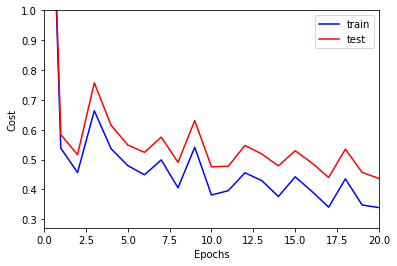

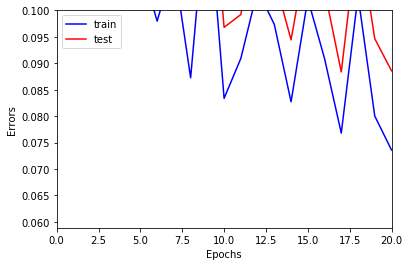

Train/test error after epoch 20: 0.073589, 0.088571


In [24]:
hyper_param_results = np.array(hyper_param_results)
best_run = hyper_param_results[np.argmin([m.test_errors_last[-1] for m in hyper_param_results[:,2]])]

best_learning_rate, best_nepochs, best_batchsize = best_run[0]
print("Best Learning Rate:", best_learning_rate, ", Best Num of Epochs:", best_nepochs, ", Best BatchSize:", best_batchsize)

best_metrics = best_run[2]
best_metrics.plot_cost_curves(ymin=0.0, ymax=1.0,logy=False)
best_metrics.plot_error_curves(ymin=0.0, ymax=0.1,logy=False)
best_metrics.print_latest_errors()


#### YOUR FINDINGS ... 


- Smaller learning rate makes the learning curve less wiggly
- Changes on the number of epochs don't necessarily increase or decrease the performance, if the optimum is reached, it just vibrating around it.
- If the optimum with a small batch size hasn't been reached, increasing the size could deliver smaller cost/error rate. But it is important to note, that after some point, a larger batch size doesn't deliver an optimum result anymore and still can be optimized.

### 1c Compute the Error Rates for the individual Digits

Now compute and print (or plot) the rate of misclassified images per digit (i.e. How many digits with label k are not been classified as label k).

Which one seems most difficult to classify?

Plot a few images of the wrongly classified images that have the label of the class that is most difficult to classify.  

Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test cost after epoch 20: 0.390680, 0.500135
Train/test error after epoch 20: 0.089018, 0.102357


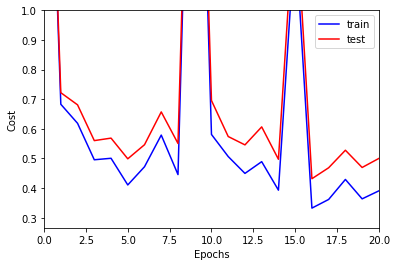

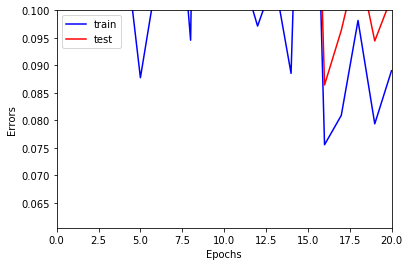

Train/test error after epoch 20: 0.089018, 0.102357


In [25]:
## Reset using best hyper params
W,b = initialize_params(28*28, 10)

### START YOUR CODE ### 

alpha = best_learning_rate
nepochs = best_nepochs
batchsize = best_batchsize

params, metrics = optimize(W, b, x_train, y_train, x_test, y_test, nepochs=nepochs, alpha=alpha, batchsize=batchsize, debug=False)

### END YOUR CODE ### 

metrics.plot_cost_curves(ymin=0.0, ymax=1.0,logy=False)
metrics.plot_error_curves(ymin=0.0, ymax=0.1,logy=False)
metrics.print_latest_errors()

In [26]:
W = params['W']
b = params['b']
y_pred = predict(W,b,x_test)

### START YOUR CODE ### 

Ypredargmax = np.argmax(y_pred, axis=0)
Ypredargmax = Ypredargmax[np.newaxis, :]
#print(Ypredargmax)
#print("y-test: ", y_test)

digits_error_rate = []
for i in range(10):
    n_cor = np.count_nonzero((Ypredargmax == y_test) & (y_test == i))
    n_fal = np.count_nonzero((Ypredargmax != y_test) & (y_test == i))
    er = n_fal/(n_cor+n_fal)
    digits_error_rate.append((i, n_cor, n_fal, er))

digits_error_rate = sorted(digits_error_rate, key=lambda x: x[3])
print("Digit Correct   Wrong     Error Rate")
for el1, el2, el3, el4 in digits_error_rate:
    print("{:<6}{:<10}{:<10}{}".format(el1, el2, el3, el4))

most_difficult = digits_error_rate[-1]
print("The most difficult digit to classify is: ", most_difficult[0]," with error rate: ", most_difficult[3])

### END YOUR CODE ### 

Digit Correct   Wrong     Error Rate
1     1599      33        0.02022058823529412
0     1347      33        0.02391304347826087
4     1279      49        0.036897590361445784
6     1254      77        0.05785123966942149
3     1325      106       0.07407407407407407
2     1306      127       0.08862526168876483
7     1299      145       0.10041551246537396
8     1137      214       0.15840118430792005
9     1090      283       0.20611798980335033
5     931       366       0.28218966846569005
The most difficult digit to classify is:  5  with error rate:  0.28218966846569005


[[1347    0    4    5    7    4    7    1    4    1]
 [   1 1599   14    4    2    3    0    1    7    1]
 [  11   11 1306   33   24    1    8    8   27    4]
 [  10    5   35 1325    4    8    1   10   22   11]
 [   4    9   10    1 1279    0    5    1    6   13]
 [  38   11   23  109   62  931   33    6   71   13]
 [  14    5   17    4   23    8 1254    0    6    0]
 [   8   13   18   17   41    1    0 1299    4   43]
 [  19   50   30   50   29   11    8    4 1137   13]
 [  10   15    3   26  195    2    1   24    7 1090]]


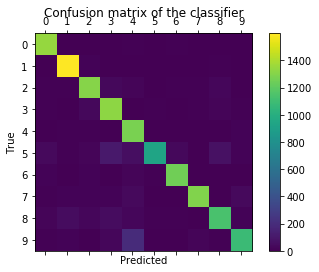

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1380
           1       0.93      0.98      0.95      1632
           2       0.89      0.91      0.90      1433
           3       0.84      0.93      0.88      1431
           4       0.77      0.96      0.85      1328
           5       0.96      0.72      0.82      1297
           6       0.95      0.94      0.95      1331
           7       0.96      0.90      0.93      1444
           8       0.88      0.84      0.86      1351
           9       0.92      0.79      0.85      1373

    accuracy                           0.90     14000
   macro avg       0.90      0.90      0.90     14000
weighted avg       0.90      0.90      0.90     14000



In [27]:
from sklearn.metrics import confusion_matrix, classification_report

labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
cm = confusion_matrix(y_test[0], Ypredargmax[0], labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xticks(np.arange(0, len(labels), 1))
plt.xlabel('Predicted')
plt.yticks(np.arange(0, len(labels), 1))
plt.ylabel('True')
plt.show()

report = classification_report(y_test[0], Ypredargmax[0])
print(report)

__Plot some misclassified of the most difficult class:__

Most difficult wrongly classified:  366


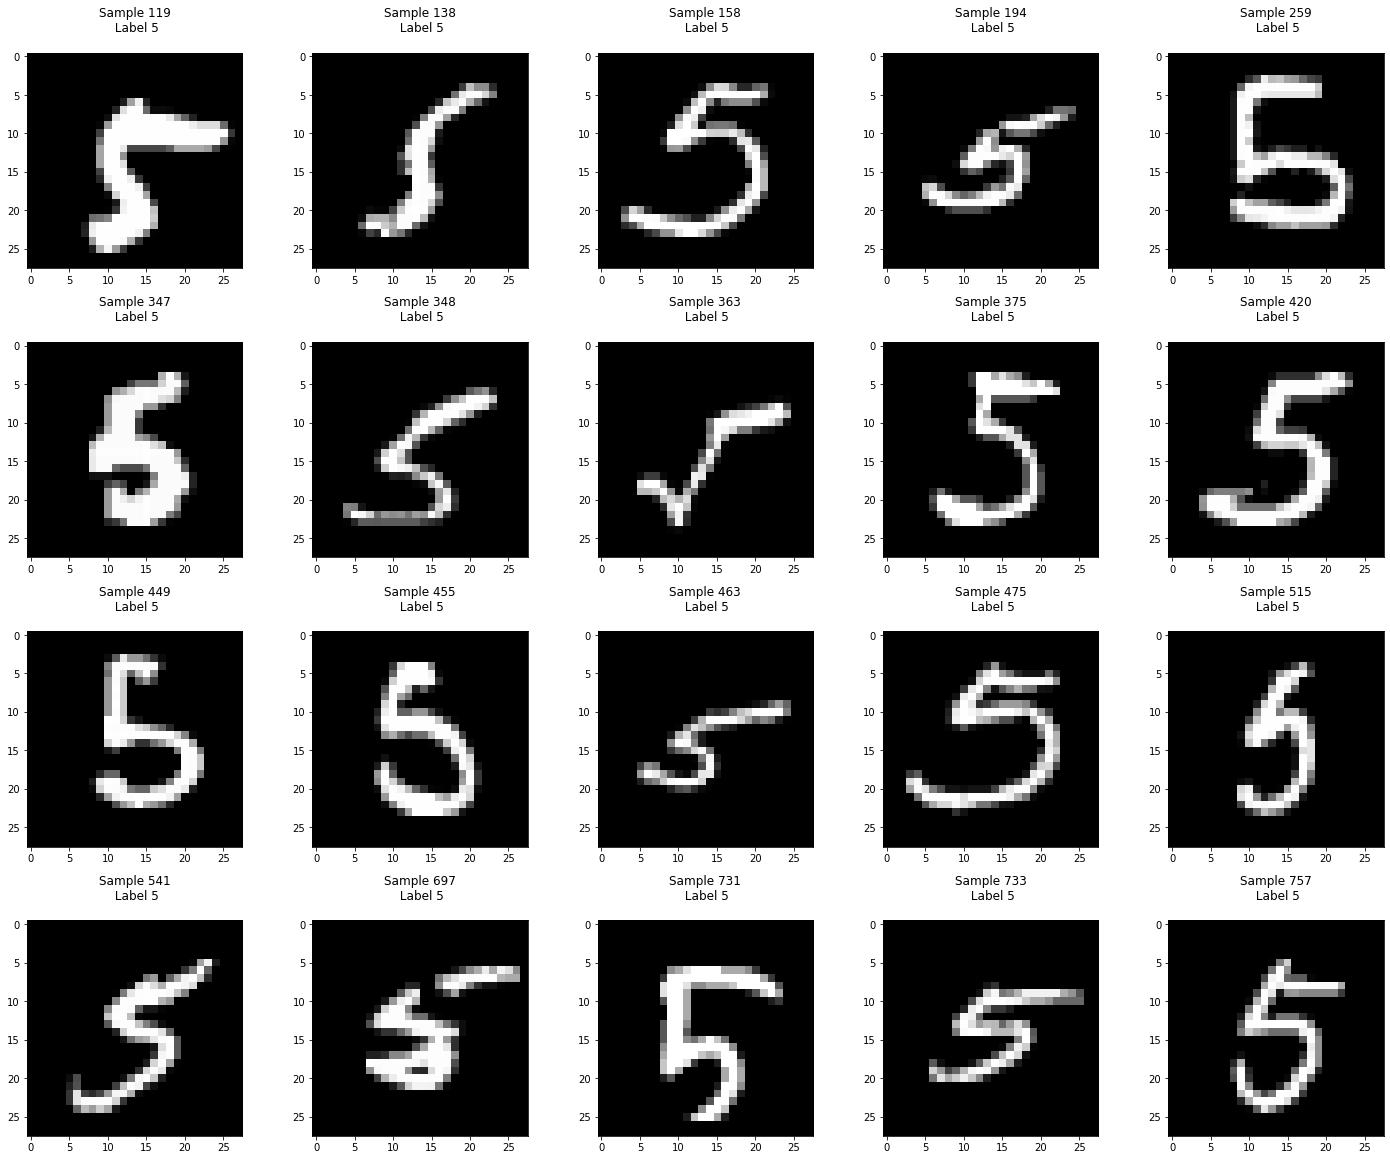

In [28]:
### START YOUR CODE ### 


most_idx = np.where((Ypredargmax != y_test) & (y_test == most_difficult[0]))[1]
print("Most difficult wrongly classified: ", len(most_idx))

plot_digits(x_test, y_test, most_idx[0:20], shape)

### END YOUR CODE ### 

### 1d Analyse Wrongly Classified Images

For the given best choice of hyper-parameters explore the mis-classified images.
Select the images the model was wrong and most uncertain with and characterize which digits were most often confused and why.
For plotting and inspecting, you can use the `plot_digits`-function defined above. 

Mis-classified:  1433


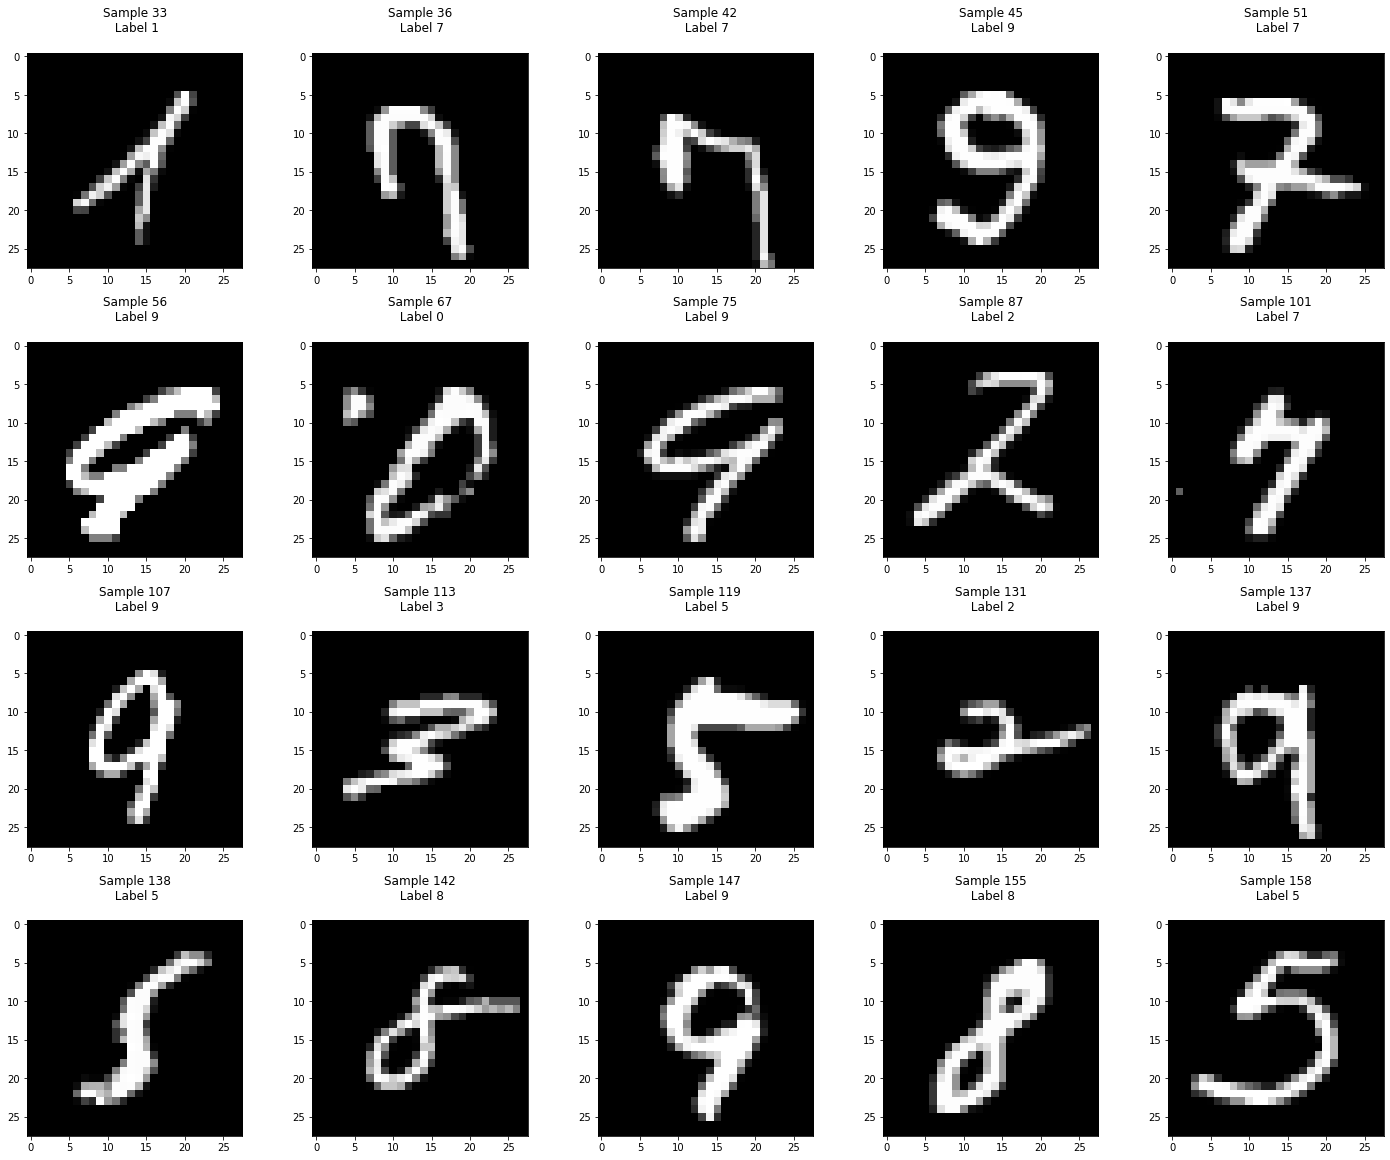

In [29]:
### START YOUR CODE ### 


wrong_idx = np.where(Ypredargmax != y_test)[1]
print("Mis-classified: ", len(wrong_idx))

plot_digits(x_test, y_test, wrong_idx[0:20], shape)


### END YOUR CODE ### 

### Plot the Trained Weights as Image 

The following cell allows you to plot the trained weights as images and the trained bias for the 10 digits. This helps to understand what the given model actually is doing. For larger (deeper) models, this won't be that easy any more. 

__QUESTION:__ 
* What could you tell about the predictions made by the model if one of the bias terms would be much larger than all the others (e.g. $b_5=10$ while $b_k\in[-0.1,0.1]$ for $k\ne5$)?

* What could you tell about the predictions made by the model if one of the bias terms would be much smaller than all the others (e.g. $b_5=-10$ while $b_k\in[-0.1,0.1]$ for $k\ne5$)?

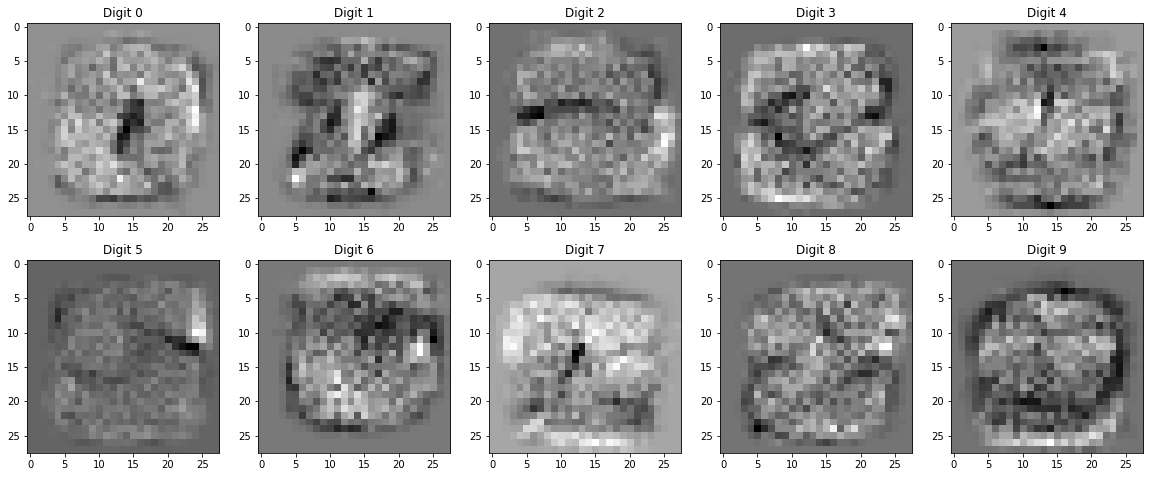

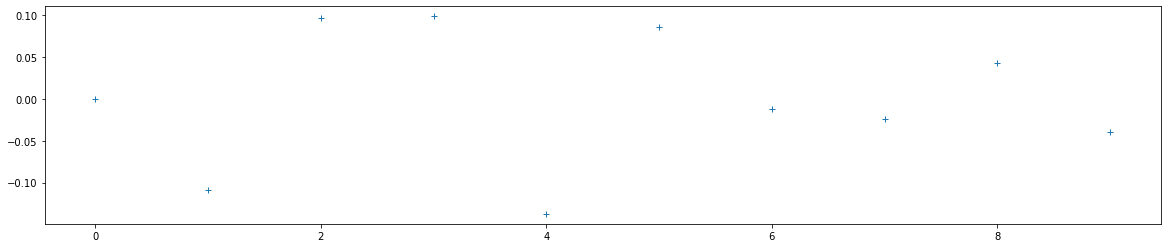

In [30]:
weights = params['W']
biases = params['b']
cols = 5
rows = 2
plt.figure(figsize=(20,4*rows))
for i in range(10):
    plt.subplot(rows, cols, i+1)
    plt.imshow(np.reshape(weights[i], (28,28)), cmap=plt.cm.gray)
    plt.title('Digit %i'%i, fontsize = 12)

plt.figure(figsize=(20,4))
plt.plot(range(10), [biases[i] for i in range(10)], '+')


### 1f Analyse Weights Initialisation 

Implement and compare the weights initialisation strategies 1.-3.

__QUESTION:__ Are there significant differences in the learning, the hyper parameter settings needed, the resulting error rates (and misclassified digits) for the different initialisation strategies? 

Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test cost after epoch 20: 0.464190, 0.609841
Train/test error after epoch 20: 0.093554, 0.108000


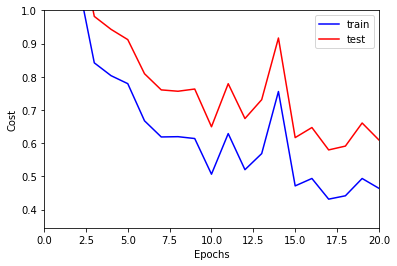

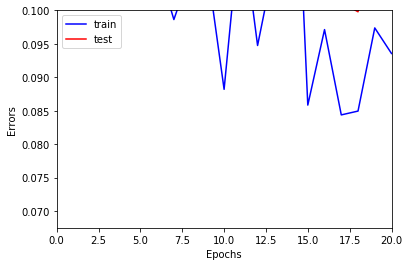

Train/test error after epoch 20: 0.093554, 0.108000


In [38]:
def initialize_params2(nx, ny):
    """
    This function provides initialized parameters: a weights matrix and a bias vector. 
    
    Argument:
    nx -- number of input features
    ny -- number of output dimensions (number of different labels)
    
    Returns:
    w -- initialized weights matrix of shape (ny,nx)
    b -- initialized bias vector of shape (ny,1)
    """
    ### START YOUR CODE ### 
    
    # initialize weights (enable one line only!) 
    # weights generated as independent standard normal random numbers (mean zero, standard deviation 1)
    w = np.random.randn(ny,nx)

    # initialize biases to zero
    b = np.zeros((ny,1))
    
    ### END YOUR CODE ### 
    
    return w, b

## Reset using best hyper params
W,b = initialize_params2(28*28, 10)

### START YOUR CODE ### 

alpha = best_learning_rate
nepochs = best_nepochs
batchsize = best_batchsize

params, metrics = optimize(W, b, x_train, y_train, x_test, y_test, nepochs=nepochs, alpha=alpha, batchsize=batchsize, debug=False)

### END YOUR CODE ### 

metrics.plot_cost_curves(ymin=0.0, ymax=1.0,logy=False)
metrics.plot_error_curves(ymin=0.0, ymax=0.1,logy=False)
metrics.print_latest_errors()

Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test cost after epoch 20: 0.400547, 0.512925
Train/test error after epoch 20: 0.090518, 0.104214


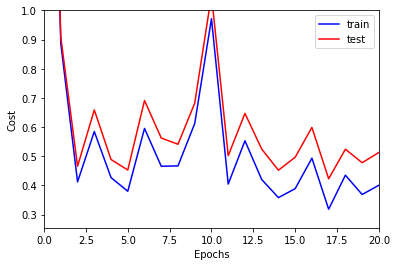

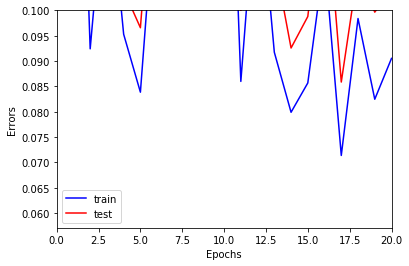

Train/test error after epoch 20: 0.090518, 0.104214


In [39]:
def initialize_params3(nx, ny):
    """
    This function provides initialized parameters: a weights matrix and a bias vector. 
    
    Argument:
    nx -- number of input features
    ny -- number of output dimensions (number of different labels)
    
    Returns:
    w -- initialized weights matrix of shape (ny,nx)
    b -- initialized bias vector of shape (ny,1)
    """
    ### START YOUR CODE ### 
    
    # initialize weights (enable one line only!)
    # weights generated as independent normal random numbers with mean zero and standard deviation properly scaled (divided by 𝑛⎯⎯√)
    w = np.random.normal(0,1/np.sqrt(nx),(ny,nx))
    
    # initialize biases to zero
    b = np.zeros((ny,1))
    
    ### END YOUR CODE ### 
    
    return w, b


## Reset using best hyper params
W,b = initialize_params3(28*28, 10)

### START YOUR CODE ### 

alpha = best_learning_rate
nepochs = best_nepochs
batchsize = best_batchsize

params, metrics = optimize(W, b, x_train, y_train, x_test, y_test, nepochs=nepochs, alpha=alpha, batchsize=batchsize, debug=False)

### END YOUR CODE ### 

metrics.plot_cost_curves(ymin=0.0, ymax=1.0,logy=False)
metrics.plot_error_curves(ymin=0.0, ymax=0.1,logy=False)
metrics.print_latest_errors()